In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [3]:
using Blink

In [4]:
robot = BoxAtlas(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 3183`, ProcessRunning), TCPSocket(RawFD(53) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(57) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 1, Nullable{Any}(true))))

In [5]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.mimic_net([22, 32, 32, 11]; regularization=1e-3)
optimizer = Flux.ADAM(Flux.params(net))

net_controller = let net = net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [6]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
#         copy!(x0, x_init)
#         set_velocity!(x0, findjoint(x0.mechanism, "floating_base"),
#             [σv * (2 * (rand() - 0.5)), 0.0, 0.0])
        LearningMPC.randomize!(x0, x_init, 0.0, σv)
#         Δv = zeros(num_velocities(x0))
#         Δv[1] = σv * (2 * rand() - 0.5)
#         set_velocity!(x0, velocity(x0) .+ Δv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 25, 
            params.lcp_solver;
            termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
        append!(data, sink.samples)
    end
end

(::#3) (generic function with 1 method)

In [7]:
library_file = "library-mimic.jld2"
dataset_file = "boxatlas-regularized-mimic.jld2"

"boxatlas-regularized-mimic.jld2"

In [8]:
# t, v = jldopen("../2018-08-20-box-atlas-miqp/library.jld2") do file
#     file["training"], file["testing"]
# end
# old_samples = vcat(t, v);
# t, v = jldopen("../2018-08-21-comparing-mimic-and-bounds/library.jld2") do file
#     file["training"], file["testing"]
# end
# append!(old_samples, t)
# append!(old_samples, v)

# t, v = jldopen("../2018-08-21-comparing-mimic-and-bounds/library-mimic.jld2") do file
#     file["training"], file["testing"]
# end
# append!(old_samples, t)
# append!(old_samples, v)

# t, v = splitobs(shuffleobs(old_samples); at=0.8)
# jldopen(library_file, "w") do file
#     file["training"] = Vector(t)
#     file["testing"] = Vector(v)
# end;

In [9]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;

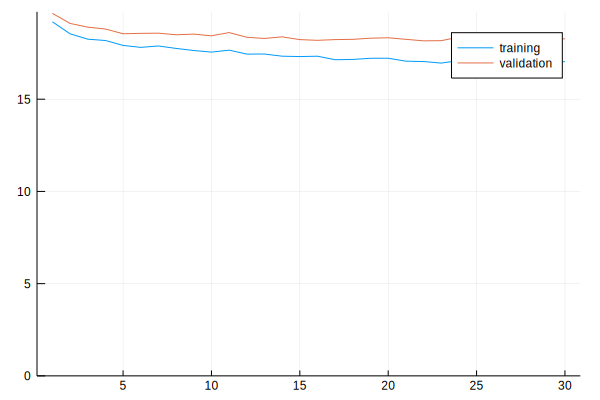

1003.022576 seconds (2.80 G allocations: 365.148 GiB, 11.17% gc time)


Progress:   5%|██                                       |  ETA: 6:55:19

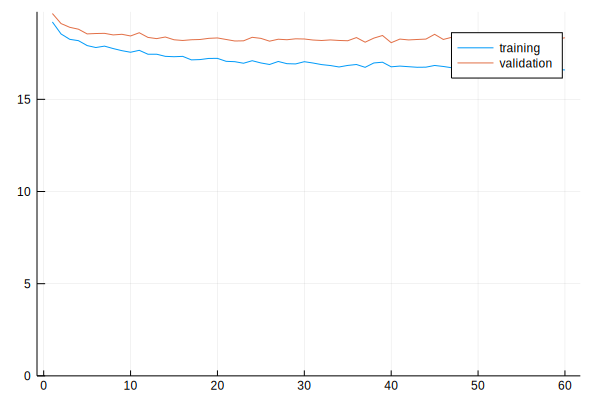

1017.790998 seconds (2.80 G allocations: 365.717 GiB, 11.64% gc time)


Progress:  10%|████                                     |  ETA: 6:32:59

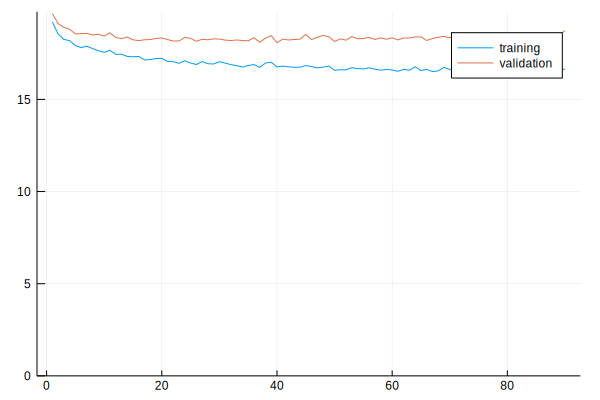

1025.278159 seconds (2.81 G allocations: 366.335 GiB, 11.73% gc time)


Progress:  15%|██████                                   |  ETA: 6:09:33

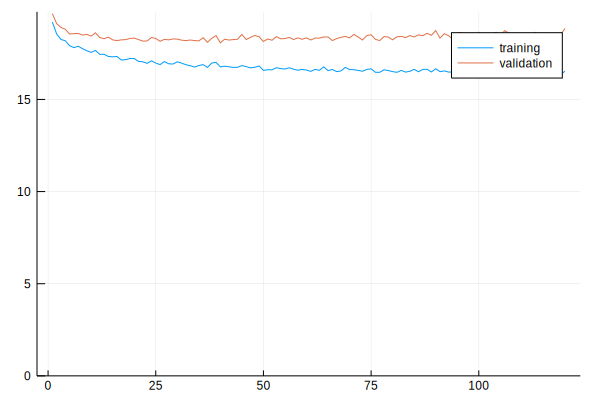

1000.745863 seconds (2.81 G allocations: 366.997 GiB, 11.91% gc time)


Progress:  20%|████████                                 |  ETA: 5:46:24

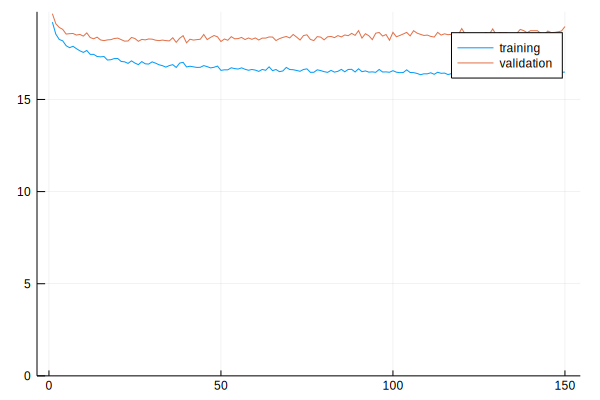

1006.085063 seconds (2.82 G allocations: 367.659 GiB, 11.78% gc time)


Progress:  25%|██████████                               |  ETA: 5:24:26

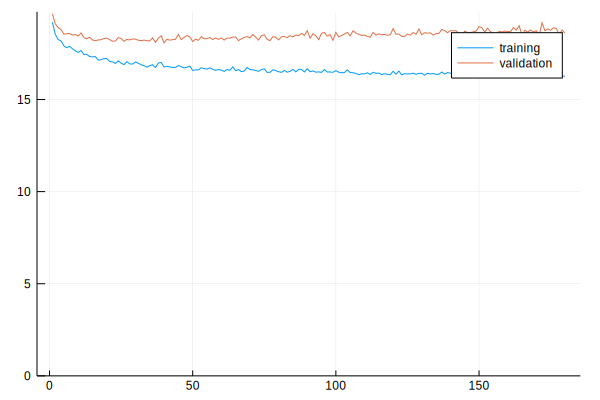

1000.868782 seconds (2.82 G allocations: 368.321 GiB, 11.88% gc time)


Progress:  30%|████████████                             |  ETA: 5:02:10

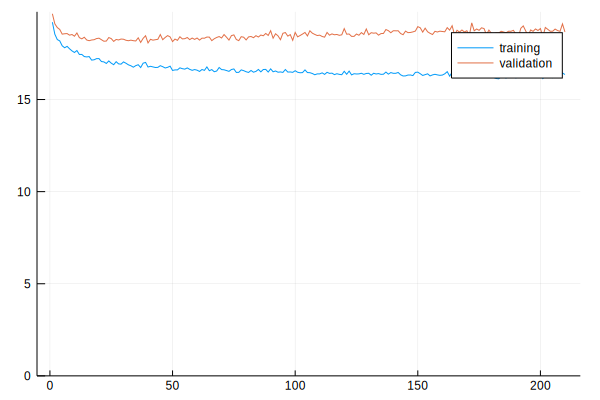

985.993777 seconds (2.83 G allocations: 368.983 GiB, 12.02% gc time)


Progress:  35%|██████████████                           |  ETA: 4:40:26

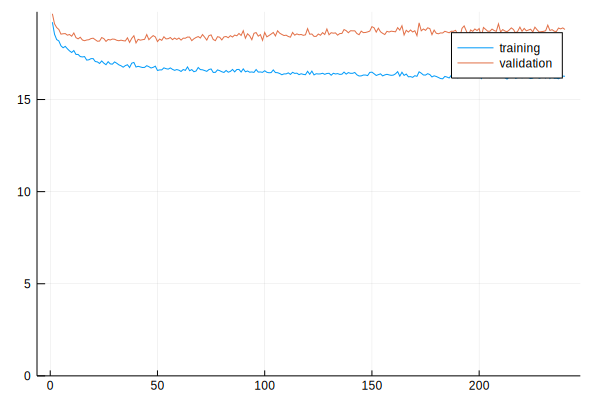

982.711066 seconds (2.83 G allocations: 369.645 GiB, 11.78% gc time)


Progress:  40%|████████████████                         |  ETA: 4:18:00

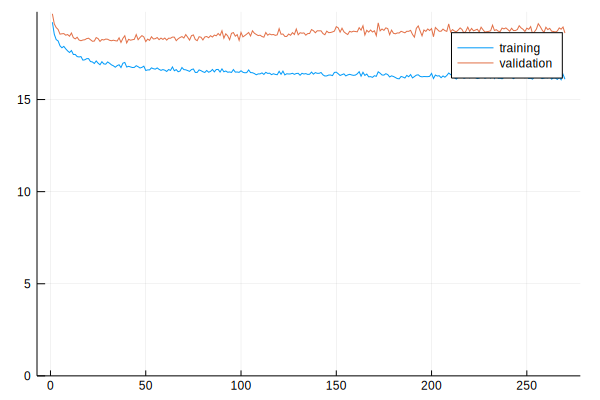

986.438383 seconds (2.84 G allocations: 370.195 GiB, 11.39% gc time)


Progress:  45%|██████████████████                       |  ETA: 3:55:37

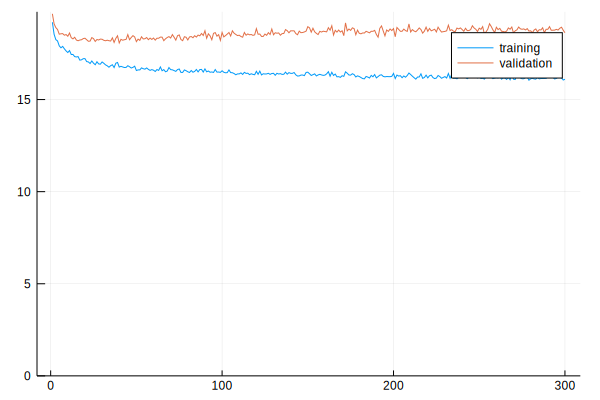

1013.322263 seconds (2.84 G allocations: 370.857 GiB, 11.89% gc time)


Progress:  50%|████████████████████                     |  ETA: 3:34:13

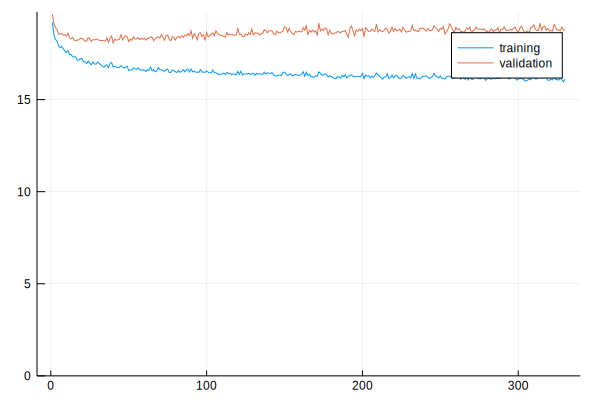

1018.598635 seconds (2.85 G allocations: 371.396 GiB, 11.85% gc time)


Progress:  55%|███████████████████████                  |  ETA: 3:12:29

captured: InterruptException()


Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] 

LoadError: [91mMethodError: no method matching LearningMPC.MPCResults{Float64}(::Void, ::Void, ::Array{Float64,1}, ::LearningMPC.MIPResults)[39m

_error(::String, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:148
 [2] byteat(::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:58
 [3] chomp_space! at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:115 [inlined]
 [4] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64}, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:158
 [5] #parse#2(::Type{Dict{String,Any}}, ::Type{Int64}, ::Function, ::TCPSocket) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:406
 [6] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Lazy/src/macros.jl:241 [inlined]
 [7] macro expansion at /home/rdeits/locomotion/explorations/learning-

In [10]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 10
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:3
        collect_into!(dataset.training_data, σv * i / N_iter)
    end
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    
    new_samples = tuple.(dataset.training_data)
    new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
    append!(all_training_data, new_training)
    append!(all_validation_data, new_validation)

    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end